# Watershed segmentation for droplet isolation

In [11]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing

from scipy import ndimage as ndi

import os

import plotly.graph_objs as go

### Read image

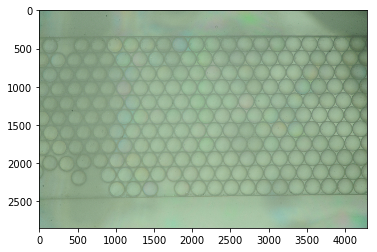

In [12]:
f = io.imread('984D300S/DSC_9331.JPG')
plt.figure(0)
plt.imshow(f)

### Convert to greyscale

RGB information depends on polarization angle making it unreliable

(2848, 4288)

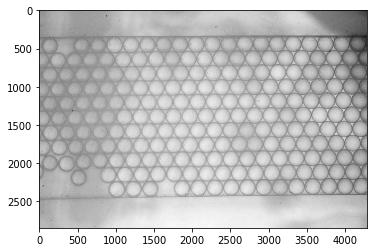

In [13]:
f_grey = rgb2gray(f)
plt.figure(1)
plt.imshow(f_grey, cmap=plt.cm.gray)
f_grey.shape

### Crop area of interest

and convert to uint (for some skimage methods)

/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning:

Possible precision loss when converting from float64 to uint8



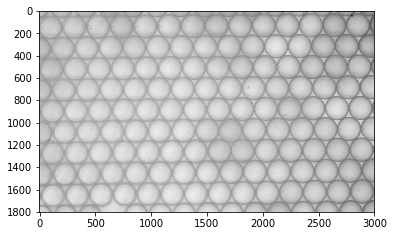

In [14]:
f_cropped = f_grey[500:2300,1000:4000] #[lines, columns]
f_uint = img_as_ubyte(f_cropped)
plt.figure(2)
plt.imshow(f_uint, cmap=plt.cm.gray)

In [15]:
f_uint.mean()

164.2137374074074

### Increase contrast

Adaptive equalization can deal with some non-uniformity in the original image

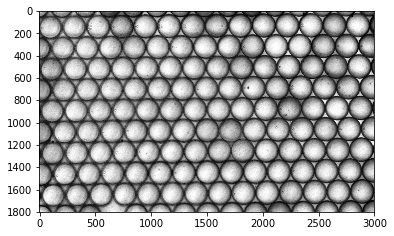

In [16]:
# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(f_uint, clip_limit=0.03)
plt.imshow(img_adapteq, cmap=plt.cm.gray)

### Threshold

Minimum threshold was found to work best in this type of image (see SegmentationDropletsInCapillary).

Minimum threshold: 0.412109375
Min intensity: 0.0
Max intensity: 1.0


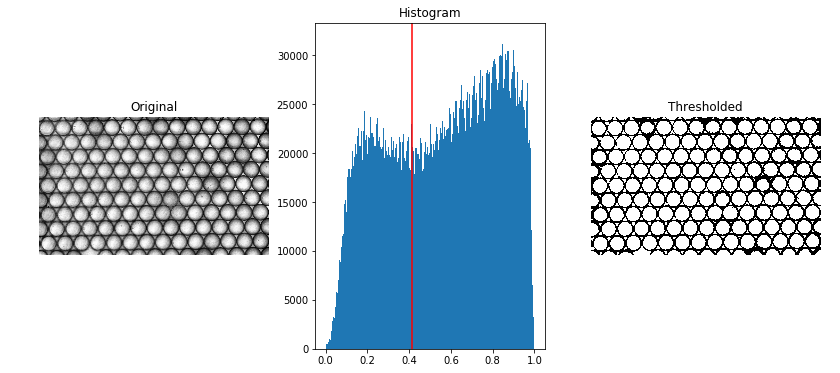

In [17]:
image = img_adapteq

thresh = threshold_minimum(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(14, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(thresh))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

### Perform Watershed segmentation

- Close to remove artifacts from contrast increase and thresholding
- Calculate the distance image, increase its contrast and mask low distance areas (at the intersection between drops)
- Find local distance maxima and use as markers for watershed
- Run the watershed algorithm to segment
- Label segmented regions

In [18]:
image = binary

# Remove dark spots and connect bright spots
closed = closing(binary)

# Calculate the distance to the dark background
distance = ndi.distance_transform_edt(closed)

# Increase contrast of the the distance image
cont_stretch = exposure.rescale_intensity(distance, in_range='image')

# Mask the distance image to remove interstitial points
masked = cont_stretch.copy()
masked[masked < 0.2] = 0

# Find local maximas of the distance image
#local_maxi = peak_local_max(cont_stretch, indices=False, footprint=np.ones((3, 3)))
local_maxi = peak_local_max(masked, indices=False, min_distance=3, threshold_abs=0.6)

# Markers for watershed are the local maxima of the distance image
markers, num_max = ndi.label(local_maxi)

# Run watershed algorithm on the inverse of the distance image
#segmented = watershed(-cont_stretch, markers, mask = image, watershed_line=True)
segmented = watershed(-masked, markers, mask = masked > 0)

# Label the segments of the image
labeled, num_sec = ndi.label(segmented)

# Color the labels sections for display
image_label_overlay = label2rgb(labeled, image=image)

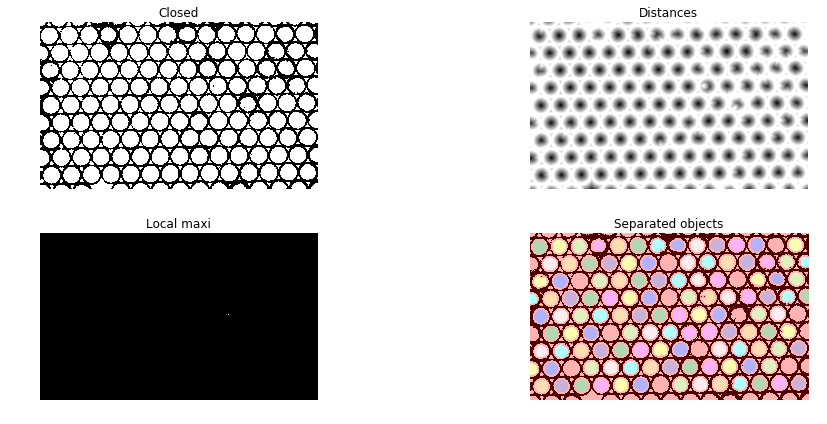

Number of maximas: 140
Number of regions: 126


In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Closed')
ax[1].imshow(-cont_stretch, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(local_maxi, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Local maxi')
ax[3].imshow(image_label_overlay, interpolation='nearest')
ax[3].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

print('Number of maximas: ' + str(num_max))
print('Number of regions: ' + str(num_sec))

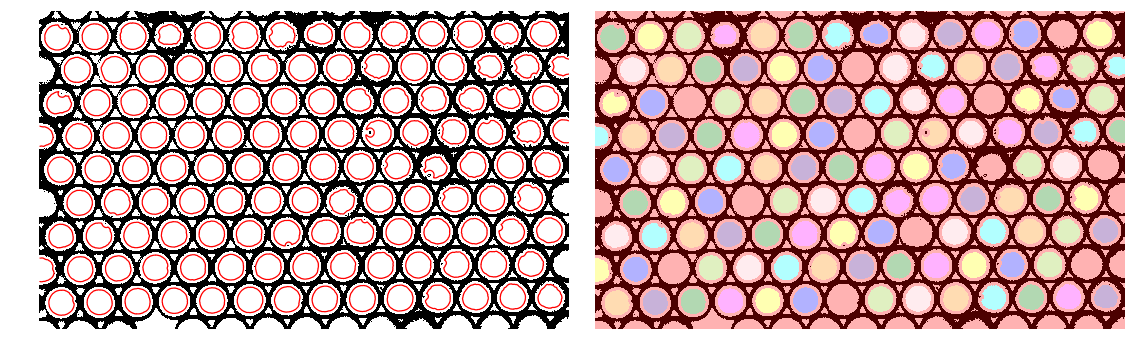

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)
axes[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmented, [0.5], linewidths=1.2, colors='r')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

### Extract the labeled regions

In [21]:
reg = regionprops(labeled, intensity_image=f_uint, coordinates='rc')
columns= ['Label', 'Area', 'Eccentricity', 'Bbox Area', 'Bbox', 'Centroid', 'Image']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image} for i in reg])
df.head(5)

,Label,Area,Eccentricity,Bbox Area,Bbox,Centroid,Image
0,1.0,16399.0,0.317203,21168.0,"(58, 2365, 205, 2509)","(129.2015976583938, 2436.7307152875173)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2.0,15755.0,0.374632,20720.0,"(59, 2781, 199, 2929)","(128.09387496033006, 2854.6130752142176)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3.0,15310.0,0.375114,20148.0,"(60, 2149, 198, 2295)","(128.3476812540823, 2221.86120182887)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4.0,16821.0,0.333880,21750.0,"(62, 1092, 212, 1237)","(137.278937042982, 1163.583496819452)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,5.0,14987.0,0.380422,19720.0,"(62, 1938, 198, 2083)","(129.25722292653634, 2009.905584840195)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Get individual images for each droplet

To be fed in the classification algorithm

126 drops where detected and segmented


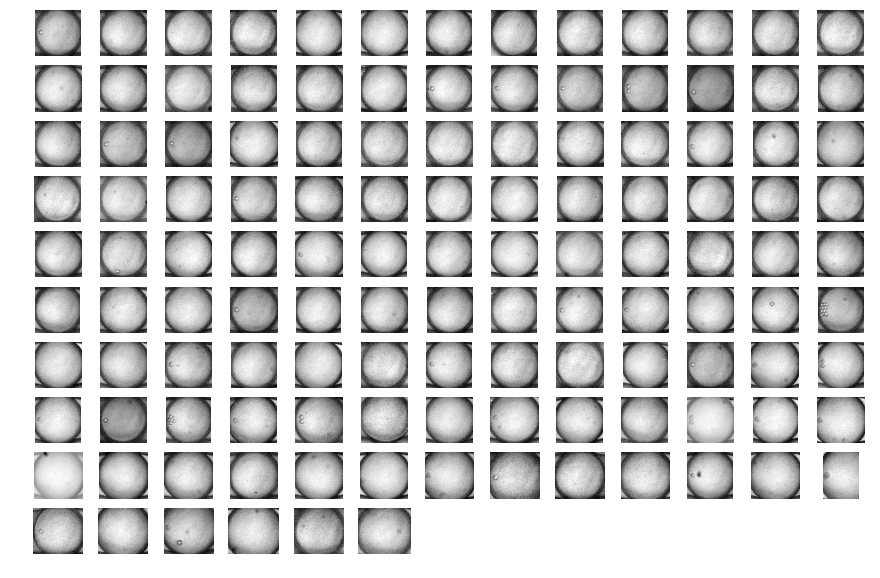

In [22]:
# Display parameters
org_img = f_uint # Intensity image
border = 25 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.65 # Eccentricity cuttoff, removes misidentified shapes (for instance half-droplets)

n_img = len(reg)
print("{} drops where detected and segmented".format(n_img))
n_col = 10
n_rows = n_img // n_col + 1

# Sort as a function of eccentricity
reg.sort(key=lambda x: x.eccentricity)
reg_clean = [region for region in reg if (region.eccentricity < ecc_cutoff)]

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(reg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    axes[i].imshow(org_img[min_row-border:max_row+border,min_col-border:max_col+border], cmap=plt.cm.gray, interpolation='nearest')
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(reg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 10)

Eccentricity cut off should be 0.65 to remove the "half droplet" segmentation misses.

In [23]:
data = [
    go.Histogram(
        x=df.Eccentricity[df.Eccentricity < 0.65],
        nbinsx = 20
        
    )
]

go.FigureWidget(
    data,
    layout = go.Layout(
        width = 600,
        height = 500,
        xaxis=dict(title='Area', linecolor = 'black',linewidth = 2, mirror = True),
        yaxis=dict(title='Bbox Area',linecolor = 'black',linewidth = 2, mirror = True),
        showlegend=False
    )
)

FigureWidget({
    'data': [{'nbinsx': 20,
              'type': 'histogram',
              'uid': 'ef690ad1-7…

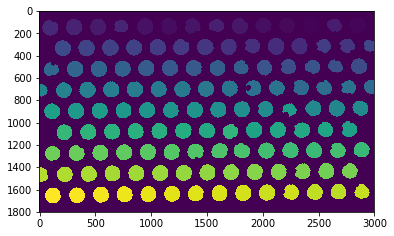

In [24]:
plt.imshow(labeled)